In [3]:
import zarr
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange

In [4]:
class ReplayDataset(Dataset):
    def __init__(self, games):
        self.root = zarr.open_group("dataset.zarr", mode="r")
        self.game_frame_indices = []  # list of (game, frame_idx)

        for game in games:
            n = self.root[game]["frames"].shape[0]
            self.game_frame_indices.extend([(game, i) for i in range(n)])

    def __len__(self):
        return len(self.game_frame_indices)

    def __getitem__(self, idx):
        game, i = self.game_frame_indices[idx]
        frame = self.root[game]["frames"][i][-1]  # shape (4, 3, 84, 84)
        return torch.from_numpy(frame).float().div_(255.0)

In [5]:
# class ReplayDataset(Dataset):
#     def __init__(self, games):
#         self.root = zarr.open_group(store="dataset.zarr", mode="r")
#         self.frames = None

#         for game in games:
#             if self.frames is None:
#                 self.frames = torch.tensor(self.root[game]["frames"][:], dtype=torch.float16) / 255.0
#             else:
#                 self.frames = torch.cat((self.frames, torch.tensor(self.root[game]["frames"][:], dtype=torch.float16) / 255.0), dim=0)

#     def __len__(self):
#         return self.frames.shape[0]

#     def __getitem__(self, idx):
#         return self.frames[idx, -1] # (3, 84, 84)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
        )
        self.act = nn.SiLU()

    def forward(self, x):
        return x + self.act(self.net(x))

In [ ]:
class Encoder(nn.Module):
    """
    (B, 3, 84, 84) → (B, 16, 512)

    - 4 conv layers
    - 2 residual blocks per layer
    - 21x21 feature map partitioned into 4x4 non-overlapping 5x5 windows -> 16 tokens
    """

    def __init__(self, in_channels=3, out_channels=512):
        super().__init__()
        self.patch = 5

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.SiLU(),
            ResidualBlock(64),
            ResidualBlock(64),
        )  # 84 → 42

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.SiLU(),
            ResidualBlock(128),
            ResidualBlock(128),
        )  # 42 → 21

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            ResidualBlock(256),
            ResidualBlock(256),
        )  # 21 → 21

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, out_channels, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            ResidualBlock(out_channels),
            ResidualBlock(out_channels),
        )  # 21 → 21

        self.projection = nn.Linear(
            self.patch * self.patch * out_channels, out_channels
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # (B, 512, 21, 21)
        x = x[:, :, 0:20, 0:20]
        x = rearrange(
            x,
            "b c (h p1) (w p2) -> b (h w) (p1 p2 c)",
            p1=self.patch,
            p2=self.patch,
        )  # (B, 16, 5*5*512)

        x = self.projection(x)  # (B, 16, 512)

        return x  # (B, 16, 512)

In [ ]:
class Decoder(nn.Module):
    """
    (B, 16, 512) → (B, 3, 84, 84)

    - reverse of Encoder
    - 16 tokens -> 4x4 grid of 5x5 patches -> (B, 512, 21, 21)
    - 4 deconv layers
    """

    def __init__(self, in_channels=512, out_channels=3):
        super().__init__()
        self.patch = 5

        self.projection = nn.Linear(
            in_channels, self.patch * self.patch * in_channels
        )

        self.deconv4 = nn.Sequential(
            ResidualBlock(in_channels),
            ResidualBlock(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1),
        )  # 21 → 21

        self.deconv3 = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.SiLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        )  # 21 → 21

        self.deconv2 = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            nn.SiLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        )  # 21 → 42

        self.deconv1 = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            nn.SiLU(),
            nn.ConvTranspose2d(
                64, out_channels, kernel_size=4, stride=2, padding=1
            ),
        )  # 42 → 84

    def forward(self, x):
        # x: (B, 16, 512)
        x = self.projection(x)  # (B, 16, 5×5×512)
        x = x.view(
            x.size(0), 4, 4, 512, self.patch, self.patch
        )  # (B, 4, 4, 512, 5, 5)
        x = x.permute(0, 3, 1, 4, 2, 5)  # (B, 512, 4, 5, 4, 5)
        x = x.reshape(x.size(0), 512, 4 * 5, 4 * 5)  # (B, 512, 20, 20)

        # 填充到 21×21（补 1 行 1 列）
        x = F.pad(x, (0, 1, 0, 1))  # (B, 512, 21, 21)

        x = self.deconv4(x)  # (B, 256, 21, 21)
        x = self.deconv3(x)  # (B, 128, 21, 21)
        x = self.deconv2(x)  # (B, 64, 42, 42)
        x = self.deconv1(x)  # (B, 3, 84, 84)

        return x

In [17]:
from vector_quantize_pytorch import VectorQuantize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

enc = Encoder().to(device)
dec = Decoder().to(device)
quantizer = VectorQuantize(
    dim=512,
    codebook_size=512,  # each table smaller
    decay=0.8,
    commitment_weight=0.1,
).to(device)

In [20]:
GAMES = [
    "SpaceInvaders",
    "Krull",
    "BeamRider",
    "Hero",
    "StarGunner",
    "MsPacman",
]

replay_dataset = ReplayDataset(GAMES)

loader = DataLoader(
    replay_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    prefetch_factor=8,
    persistent_workers=True,
)

In [ ]:
from collections import deque
import itertools
from tqdm import tqdm
import math

opt = torch.optim.AdamW(
    [
        {
            "params": itertools.chain(enc.parameters(), dec.parameters()),
            "lr": 3e-4,
            "weight_decay": 1e-4,
        },
        {"params": quantizer.parameters(), "lr": 1e-4, "weight_decay": 0.0},
    ]
)

criterion = nn.MSELoss()  # pixel-space recon loss


def codebook_stats(indices, num_codes):
    flat = indices.reshape(-1)
    hist = torch.bincount(flat, minlength=num_codes).float()
    probs = hist / hist.sum()
    perplexity = torch.exp(-(probs * probs.log().nan_to_num()).sum())
    used_pct = (hist > 0).float().mean().item() * 100
    return perplexity.item(), used_pct


# --- EMA helpers so the bar isn’t jittery -------------------
def ema(old, new, m=0.98):  # m close to 1 ⇒ slow
    return new if old is None else old * m + new * (1 - m)


ema_recon = ema_psnr = ema_vq = ema_pplx = ema_used = None
window_indices = deque(maxlen=10)  # 10 most recent batches


for epoch in range(100):  # 100 epochs
    bar = tqdm(loader, leave=True, desc=f"Epoch {epoch + 1:02d}")
    for batch in bar:
        batch = batch.to(device, non_blocking=True)

        # forward ---------------
        z_c = enc(batch)
        z_q, idx, vq = quantizer(z_c)
        x_hat = dec(z_q)

        recon_loss = criterion(x_hat, batch)
        loss = recon_loss + vq

        # torch.nn.utils.clip_grad_norm_(enc.parameters(), 1.0)
        # backward --------------
        opt.zero_grad()
        loss.backward()
        opt.step()

        # running stats ---------
        psnr = 10 * math.log10(1.0 / recon_loss.item())

        window_indices.append(idx.detach())
        if len(window_indices) == window_indices.maxlen:
            cat_idx = torch.cat(list(window_indices), 0)
            pplx, used = codebook_stats(cat_idx, quantizer.codebook_size)
        else:  # too few batches yet
            pplx, used = float("nan"), float("nan")

        ema_recon = ema(ema_recon, recon_loss.item())
        ema_psnr = ema(ema_psnr, psnr)
        ema_vq = ema(ema_vq, vq.item())
        if not math.isnan(pplx):
            ema_pplx = ema(ema_pplx, pplx)
            ema_used = ema(ema_used, used)
        # progress-bar text -----
        bar.set_postfix(
            mse=f"{ema_recon:6.6f}",
            psnr=f"{ema_psnr:5.2f}",
            vq=f"{ema_vq:6.6f}",
            pplx=f"{ema_pplx:6.1f}" if ema_pplx else "--",
            used=f"{ema_used:5.1f}%" if ema_used else "--",
        )

Epoch 08:   0%|          | 2/1173 [00:03<29:17,  1.50s/it, mse=0.000803, pplx=270.0, psnr=30.96, used=99.5%, vq=0.000003]


KeyboardInterrupt: 

In [ ]:
from safetensors.torch import save_file

encoder_state = enc.state_dict()
vq_state = quantizer.state_dict()
decoder_state = dec.state_dict()

save_file(
    encoder_state,
    "encoder.safetensors",
)
save_file(
    vq_state,
    "vq.safetensors",
)
save_file(
    decoder_state,
    "decoder.safetensors",
)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from torchvision.utils import make_grid
import imageio
from vector_quantize_pytorch import VectorQuantize
from pathlib import Path

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder_state = load_file("encoder.safetensors")
vq_state = load_file("vq.safetensors")
decoder_state = load_file("decoder.safetensors")

encoder = Encoder().to(device)
quantizer = VectorQuantize(
    dim=512,
    codebook_size=512,  # each table smaller
    decay=0.8,
    commitment_weight=0.1,
).to(device)
decoder = Decoder().to(device)

encoder.load_state_dict(encoder_state)
quantizer.load_state_dict(vq_state)
decoder.load_state_dict(decoder_state)

encoder.to(device)
quantizer.to(device)
decoder.to(device)

encoder.eval()
quantizer.eval()
decoder.eval()

Decoder(
  (projection): Linear(in_features=512, out_features=12800, bias=True)
  (deconv4): Sequential(
    (0): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (act): SiLU()
    )
    (1): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (act): SiLU()
    )
    (2): SiLU()
    (3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (deconv3): Sequential(
    (0): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    

In [ ]:
GAMES = [
    "SpaceInvaders",
    "Krull",
    "BeamRider",
    "Hero",
    "StarGunner",
    "MsPacman",
]

replay_dataset = ReplayDataset(GAMES)

In [37]:
frames = replay_dataset.root["Hero"]["frames"][:]

In [38]:
T = frames.shape[0]
val_tail = int(0.01 * T)  # last 5 % acts as “validation”
idx = np.random.choice(np.arange(T - val_tail, T), size=4, replace=False)

In [39]:
idx

array([50012, 49703, 49763, 49569])

In [ ]:
# frames: (N,4,84,84,3) uint8  →  (N,12,84,84) float32 in [0,1]
with torch.no_grad():
    batch = (
        torch.from_numpy(frames[idx, -1])
        .float()
        .div_(255)
        .to(device, non_blocking=True)
    )

    z_c = encoder(batch)
    z_q, *_ = quantizer(z_c)
    recon = decoder(z_q).clamp(0, 1).cpu()  # back to CPU for plotting

batch = batch.cpu()  # originals on CPU too

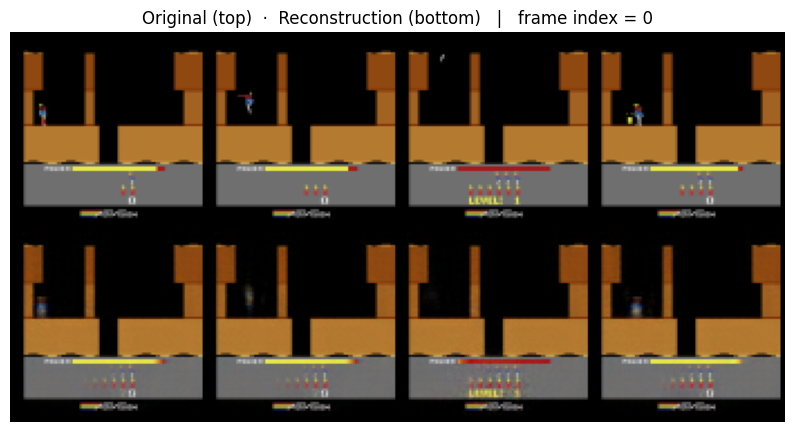

In [41]:
sub = 0  # 0=oldest … 3=most-recent stacked frame


def slice_rgb(x, k=sub):
    """x : (B,12,H,W)  →  (B,3,H,W)  selecting RGB of k-th stacked frame"""
    return x[:, k * 3 : k * 3 + 3]


batch_rgb = slice_rgb(batch)  # originals
recon_rgb = slice_rgb(recon)  # reconstructions

both_rgb = torch.cat([batch_rgb, recon_rgb], dim=0)  # 64,3,H,W
grid = make_grid(both_rgb, nrow=4, padding=2)

plt.figure(figsize=(10, 6))
plt.title(
    "Original (top)  ·  Reconstruction (bottom)   |   frame index = " f"{sub}"
)
plt.imshow(grid.permute(1, 2, 0))  # CHW → HWC, now 3 channels ⇒ OK
plt.axis("off")
plt.show()